# Importing libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from sklearn.impute import SimpleImputer
from sklearn.neighbors import LocalOutlierFactor
from scipy.stats import probplot
from scipy.stats import zscore 

# Uploading the data

In [2]:
df=pd.read_csv("Data/water_dataX.csv")
gdf = gpd.read_file('Data/india-states/Igismap/Indian_States.shp')
#Selectionner seulement les 1900 examples premiers car les autres exemples incorect 
#en plus contient beaucoup des donneés aberantes
df = df.iloc[0:1901, :]

In [3]:
#afficher les 5 premiére lignes
df.head(5)

,STATION CODE,LOCATIONS,STATE,Temp,D.O. (mg/l),PH,CONDUCTIVITY (�mhos/cm),B.O.D. (mg/l),NITRATENAN N+ NITRITENANN (mg/l),FECAL COLIFORM (MPN/100ml),TOTAL COLIFORM (MPN/100ml)Mean,year
0,1393,"DAMANGANGA AT D/S OF MADHUBAN, DAMAN",DAMAN & DIU,30.6,6.7,7.5,203,NAN,0.1,11,27,2014
1,1399,ZUARI AT D/S OF PT. WHERE KUMBARJRIA CANAL JOI...,GOA,29.8,5.7,7.2,189,2,0.2,4953,8391,2014
2,1475,ZUARI AT PANCHAWADI,GOA,29.5,6.3,6.9,179,1.7,0.1,3243,5330,2014
3,3181,RIVER ZUARI AT BORIM BRIDGE,GOA,29.7,5.8,6.9,64,3.8,0.5,5382,8443,2014
4,3182,RIVER ZUARI AT MARCAIM JETTY,GOA,29.5,5.8,7.3,83,1.9,0.4,3428,5500,2014


In [4]:
#afficher la taille du dataframe (nb_lignes,nb_colonnes)
df.shape

(1901, 12)

In [6]:
#afficher les types des données dans chaque variables du dataframe
df.dtypes

STATION CODE                        object
LOCATIONS                           object
STATE                               object
Temp                                object
D.O. (mg/l)                         object
PH                                  object
CONDUCTIVITY (�mhos/cm)             object
B.O.D. (mg/l)                       object
NITRATENAN N+ NITRITENANN (mg/l)    object
FECAL COLIFORM (MPN/100ml)          object
TOTAL COLIFORM (MPN/100ml)Mean      object
year                                 int64
dtype: object

In [7]:
df.nunique()

STATION CODE                         321
LOCATIONS                            656
STATE                                203
Temp                                 179
D.O. (mg/l)                          166
PH                                   185
CONDUCTIVITY (�mhos/cm)              971
B.O.D. (mg/l)                        404
NITRATENAN N+ NITRITENANN (mg/l)     469
FECAL COLIFORM (MPN/100ml)           819
TOTAL COLIFORM (MPN/100ml)Mean      1061
year                                  10
dtype: int64

# Data Cleaning

In [8]:
#convertir le types des donneés d'un certains variables en float
df['Temp']=pd.to_numeric(df['Temp'], errors='coerce')
df['D.O. (mg/l)']=pd.to_numeric(df['D.O. (mg/l)'], errors='coerce')
df['PH']=pd.to_numeric(df['PH'], errors='coerce')
df['CONDUCTIVITY (�mhos/cm)']=pd.to_numeric(df['CONDUCTIVITY (�mhos/cm)'], errors='coerce')
df['B.O.D. (mg/l)']=pd.to_numeric(df['B.O.D. (mg/l)'], errors='coerce')
df['NITRATENAN N+ NITRITENANN (mg/l)']=pd.to_numeric(df['NITRATENAN N+ NITRITENANN (mg/l)'], errors='coerce')
df['FECAL COLIFORM (MPN/100ml)']=pd.to_numeric(df['FECAL COLIFORM (MPN/100ml)'], errors='coerce')
df['TOTAL COLIFORM (MPN/100ml)Mean']=pd.to_numeric(df['TOTAL COLIFORM (MPN/100ml)Mean'], errors='coerce')

In [9]:
df.dtypes

STATION CODE                         object
LOCATIONS                            object
STATE                                object
Temp                                float64
D.O. (mg/l)                         float64
PH                                  float64
CONDUCTIVITY (�mhos/cm)             float64
B.O.D. (mg/l)                       float64
NITRATENAN N+ NITRITENANN (mg/l)    float64
FECAL COLIFORM (MPN/100ml)          float64
TOTAL COLIFORM (MPN/100ml)Mean      float64
year                                  int64
dtype: object

In [10]:
#renommer les variables par des target plus simplement à utiliser que les anciennes 
df = df.rename(columns={'D.O. (mg/l)': 'DO'})
df = df.rename(columns={'CONDUCTIVITY (�mhos/cm)': 'CONDUCTIVITY'})
df = df.rename(columns={'B.O.D. (mg/l)': 'BOD'})
df = df.rename(columns={'NITRATENAN N+ NITRITENANN (mg/l)': 'NITRATE_N_NITRITE_N'})
df = df.rename(columns={'FECAL COLIFORM (MPN/100ml)': 'FECAL_COLIFORM'})
df = df.rename(columns={'TOTAL COLIFORM (MPN/100ml)Mean': 'TOTAL_COLIFORM'})
df.head(5)

,STATION CODE,LOCATIONS,STATE,Temp,DO,PH,CONDUCTIVITY,BOD,NITRATE_N_NITRITE_N,FECAL_COLIFORM,TOTAL_COLIFORM,year
0,1393,"DAMANGANGA AT D/S OF MADHUBAN, DAMAN",DAMAN & DIU,30.6,6.7,7.5,203.0,NaN,0.1,11.0,27.0,2014
1,1399,ZUARI AT D/S OF PT. WHERE KUMBARJRIA CANAL JOI...,GOA,29.8,5.7,7.2,189.0,2.0,0.2,4953.0,8391.0,2014
2,1475,ZUARI AT PANCHAWADI,GOA,29.5,6.3,6.9,179.0,1.7,0.1,3243.0,5330.0,2014
3,3181,RIVER ZUARI AT BORIM BRIDGE,GOA,29.7,5.8,6.9,64.0,3.8,0.5,5382.0,8443.0,2014
4,3182,RIVER ZUARI AT MARCAIM JETTY,GOA,29.5,5.8,7.3,83.0,1.9,0.4,3428.0,5500.0,2014


In [11]:
# Remplacer la chaine de caractere NAN valeur par la valeur NAN (np.nan)
def convert_to_nan(df):
    #récupère le nombre de colonnes dans df en utilisant l'attribut shape de l'objet DataFrame
    #qui renvoie un tuple contenant le nombre de lignes et de colonnes
    n_col = df.shape[1] 
    #on parcourt chaque colonne du DataFrame df à l'aide de la boucle for et index
    for index in range(n_col):
        #La ligne df.iloc[:, index] permet d'accéder à toutes les lignes de la colonne correspondante.
        #La méthode replace() est ensuite appliquée à la colonne pour remplacer chaque occurrence 
        #de la chaîne de caractères "NAN" par la valeur NaN de la bibliothèque Numpy. 
        df.iloc[:, index]  = df.iloc[:, index].replace("NAN", np.nan)
    return df

df = convert_to_nan(df)

In [12]:
df.shape

(1901, 12)

Check for missing values

<AxesSubplot:title={'center':'Missing Values Per Feature'}>

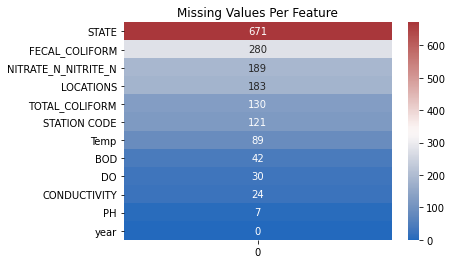

In [13]:
plt.title('Missing Values Per Feature')
nans = df.isna().sum().sort_values(ascending=False).to_frame()
sns.heatmap(nans,annot=True,fmt='d',cmap='vlag')

Comme j’ai 1900 exemples de formation, je peux remplacer chaque valeur manquante par la médiane de la colonne (pour éviter les valeurs aberrantes)

In [14]:
df_num = df.select_dtypes(exclude="object")# Selectioner les donneés numériques
df_num_col = df_num.columns 
imputer = SimpleImputer(strategy="median")#crée un objet imputer à l'aide de la classe SimpleImputer
#Remplacer toutes les valeurs manquantes dans les données numériques par la valeur médiane de chaque colonne
df_num = imputer.fit_transform(df_num)
df_num = pd.DataFrame(df_num, columns=df_num_col)

In [15]:
# Filling Categorical missing values
df_temp = df.select_dtypes(include="object")
df_temp.isnull().sum()

STATION CODE    121
LOCATIONS       183
STATE           671
dtype: int64

In [16]:
# ici on peut remplir ces valeurs par observer les autres attributs
# Exemple - 
pd.set_option('mode.chained_assignment', None)
df_temporaire = df_temp.copy()

df_temporaire[df_temporaire["STATION CODE"] == "1330"]
# Station Code qui a la valeur 1330 du Location - TAMBIRAPARANI qui appartient à STATE - TAMIL NADU
#je peux remplacer les occuerences du valeur NAN dans la case STATE par TAMILNADU
df_temporaire["STATE"][df_temporaire["STATION CODE"] == "1330"] = df_temporaire["STATE"][df_temporaire["STATION CODE"] == "1330"].fillna("TAMILNADU")

df_temporaire[df_temporaire["STATION CODE"] == "1330"]

,STATION CODE,LOCATIONS,STATE
166,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
424,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
677,1330,TAMBIRAPARANI AT ARUMUGANERI,TAMILNADU
1168,1330,TAMBIRAPARANI AT ARUMUGANERI,TAMILNADU
1351,1330,NaN,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU"
1513,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1626,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1745,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU


In [17]:
# Les valeurs NULL dans l’attribut LOCATION sont dans l’attribut STATE (ex - au-dessus du dataframe)
# Ainsi, je remplirai les valeurs NULL dans l’attribut LOCATION avec la valeur STATE correspondante
# Et la valeur d’état sera remplacée par la fonction "fill_state" définie en dessous de cette cellule

def fill_locations(df_cat):
    location_null = df_cat[df_cat["LOCATIONS"].isnull()]
    location_null_indices = location_null.index
    for index in location_null_indices:
        state_value = location_null["STATE"][index]
        location_null["LOCATIONS"][index] = state_value
        location_null["STATE"][index] = np.nan
    df_cat[df_cat["LOCATIONS"].isnull()] = location_null
    return

fill_locations(df_temporaire)
df_temporaire[df_temporaire["STATION CODE"] == "1330"]

,STATION CODE,LOCATIONS,STATE
166,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
424,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
677,1330,TAMBIRAPARANI AT ARUMUGANERI,TAMILNADU
1168,1330,TAMBIRAPARANI AT ARUMUGANERI,TAMILNADU
1351,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",NaN
1513,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1626,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1745,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU


In [18]:
df_temporaire[df_temporaire["LOCATIONS"] == "TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU"]

,STATION CODE,LOCATIONS,STATE
166,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
424,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1351,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",NaN
1513,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1626,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1745,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1896,NaN,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",NaN


In [19]:
# je peux remplir les valeurs NULL du code de la station avec la valeur LOCATION correspondante (ex - au-dessus de la base de données)
#je vais faire la valeur LOCATION correspondante avec une autre valeur LOCATION identique et insérera la valeur du code station

def fill_code(df_cat):
    station_null = df_cat[df_cat["STATION CODE"].isnull()]
    station_null_indices = station_null.index
    for index in station_null_indices:
        stat_code = np.nan
        location_index = station_null["LOCATIONS"][index]
        code_at_location = df_cat["STATION CODE"][df_cat["LOCATIONS"] == location_index]
        for index_code in code_at_location.index:
            if (code_at_location[index_code] != np.nan):
                stat_code = code_at_location[index_code]
                break
        station_null["STATION CODE"][index] = stat_code
    df_cat[df_cat["STATION CODE"].isnull()] = station_null
    return

fill_code(df_temporaire)
df_temporaire[df_temporaire["LOCATIONS"] == "TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU"]

,STATION CODE,LOCATIONS,STATE
166,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
424,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1351,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",NaN
1513,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1626,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1745,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1896,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",NaN


In [20]:
# Remplissage de toutes les valeurs NAN d’état qui ont une valeur de code de station correspondante
def fill_state(df_cat):
    station_code = df_cat["STATION CODE"].unique()
    for index in range(station_code.shape[0]):
        if (station_code[index] != np.nan):
            df_state = df_cat["STATE"][df_cat["STATION CODE"] == station_code[index]] 
            state_values = df_cat["STATE"][df_cat["STATION CODE"] == station_code[index]]
            state = np.nan
            for index_state in range(state_values.shape[0]):
                if (state_values.iloc[index_state] != np.nan):
                    state = state_values.iloc[index_state]
                    break
            df_state_fill = df_state.fillna(state) 
            df_cat["STATE"][df_cat["STATION CODE"] == station_code[index]] = df_state_fill
    return
fill_state(df_temporaire)
df_temporaire[df_temporaire["STATION CODE"] == "1330"]

,STATION CODE,LOCATIONS,STATE
166,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
424,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
677,1330,TAMBIRAPARANI AT ARUMUGANERI,TAMILNADU
1168,1330,TAMBIRAPARANI AT ARUMUGANERI,TAMILNADU
1351,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1513,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1626,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1745,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1896,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU


In [21]:
df_temporaire.isnull().sum()

STATION CODE     4
LOCATIONS        2
STATE           12
dtype: int64

In [22]:
df_temporaire[df_temporaire["STATE"].isnull()]

,STATION CODE,LOCATIONS,STATE
260,NaN,NaN,NaN
431,NaN,NaN,NaN
1106,1207,KABBANI AT MUTHANKARA,NaN
1107,1208,BHAVANI AT ELACHIVAZHY,NaN
1650,2047,"NNANCHOE (ATTAWA CHOE), CHANDIGARH",NaN
1651,2048,"PATIALA KI RAO, CHANDIGARH",NaN
1652,2049,"SUKHNA CHOE, CHANDIGARH",NaN
1770,2047,NNANCHOE (ATTAWA CHOE),NaN
1771,2048,PATIALA KI RAO,NaN
1772,2049,SUKHNA CHOE,NaN


In [23]:
# Le premier emplacement KABBANI AT MUTHANKARA est dans l’ÉTAT Kerela
df_temporaire["STATE"][1106] = "KERALA"
df_temporaire["STATE"][1107] = "KERALA"
df_temporaire["STATE"][1650] = "CHANDIGARH"
df_temporaire["STATE"][1651] = "CHANDIGARH"
df_temporaire["STATE"][1652] = "CHANDIGARH"
df_temporaire["STATE"][1770] = "CHANDIGARH"
df_temporaire["STATE"][1771] = "CHANDIGARH"
df_temporaire["STATE"][1772] = "CHANDIGARH"
df_temporaire["STATE"][1784] = "DAMAN & DIU"
df_temporaire["STATE"][1785] = "DAMAN & DIU"
df_temporaire["STATION CODE"][1784] = "0000" 
df_temporaire["STATION CODE"][1785] = "0000"

<AxesSubplot:title={'center':'Missing Values Per Feature'}>

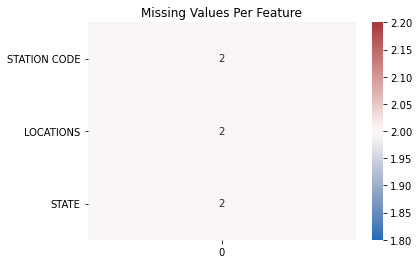

In [24]:
df_res = df_temporaire
plt.title('Missing Values Per Feature')
nans = df_res.isna().sum().sort_values(ascending=False).to_frame()
sns.heatmap(nans,annot=True,fmt='d',cmap='vlag')

<AxesSubplot:title={'center':'Missing Values Per Feature'}>

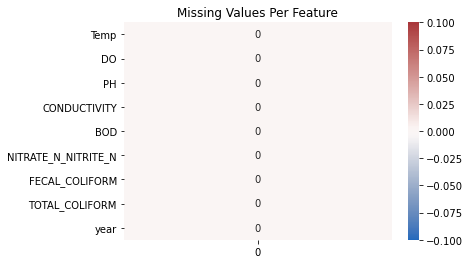

In [25]:
plt.title('Missing Values Per Feature')
nans = df_num.isna().sum().sort_values(ascending=False).to_frame()
sns.heatmap(nans,annot=True,fmt='d',cmap='vlag')

<AxesSubplot:title={'center':'Missing Values Per Feature'}>

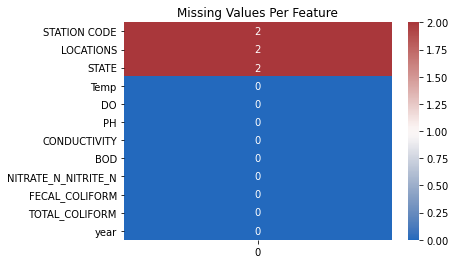

In [26]:
df_final = pd.concat([df_res, df_num], axis=1)
plt.title('Missing Values Per Feature')
nans = df_final.isna().sum().sort_values(ascending=False).to_frame()
sns.heatmap(nans,annot=True,fmt='d',cmap='vlag')

Maintenant,je veux supprimer toutes les lignes qui contiennent une valeur nulle. je le fais parce qu’il est important d’effectuer des étapes de nettoyage des données, car cela rendra mon modèle plus efficace.

<AxesSubplot:title={'center':'Missing Values Per Feature'}>

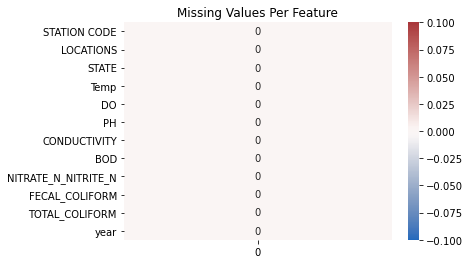

In [27]:
# Ce sont les exemples qui ne contiennent aucun attribut
# Les attributs remplis sont la médiane des colonnes correspondantes
# Il est donc préférable de les supprimer
df_null = df_final[(df_final["STATION CODE"].isnull()) & (df_final["LOCATIONS"].isnull()) & (df_final["STATE"].isnull())]
df_null_indices = df_null.index
df_final.drop(df_null_indices, axis=0, inplace=True)
df_null
plt.title('Missing Values Per Feature')
nans = df_final.isna().sum().sort_values(ascending=False).to_frame()
sns.heatmap(nans,annot=True,fmt='d',cmap='vlag')

In [28]:
df_final.head(5)

,STATION CODE,LOCATIONS,STATE,Temp,DO,PH,CONDUCTIVITY,BOD,NITRATE_N_NITRITE_N,FECAL_COLIFORM,TOTAL_COLIFORM,year
0,1393,"DAMANGANGA AT D/S OF MADHUBAN, DAMAN",DAMAN & DIU,30.6,6.7,7.5,203.0,1.9,0.1,11.0,27.0,2014.0
1,1399,ZUARI AT D/S OF PT. WHERE KUMBARJRIA CANAL JOI...,GOA,29.8,5.7,7.2,189.0,2.0,0.2,4953.0,8391.0,2014.0
2,1475,ZUARI AT PANCHAWADI,GOA,29.5,6.3,6.9,179.0,1.7,0.1,3243.0,5330.0,2014.0
3,3181,RIVER ZUARI AT BORIM BRIDGE,GOA,29.7,5.8,6.9,64.0,3.8,0.5,5382.0,8443.0,2014.0
4,3182,RIVER ZUARI AT MARCAIM JETTY,GOA,29.5,5.8,7.3,83.0,1.9,0.4,3428.0,5500.0,2014.0


In [29]:
df_final.shape

(1899, 12)

# EDA 

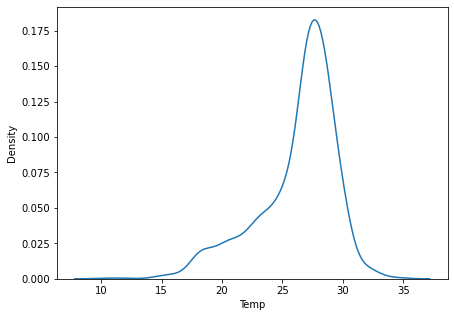

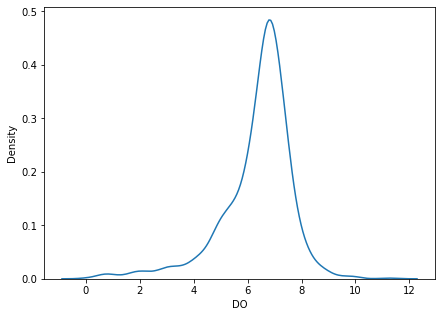

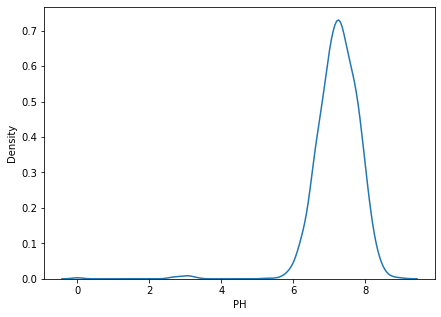

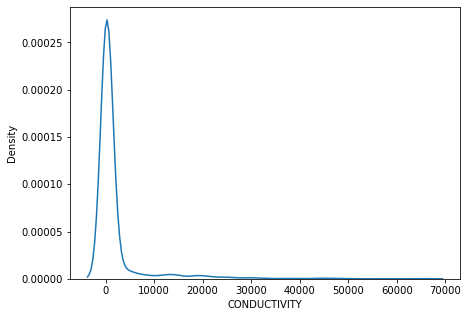

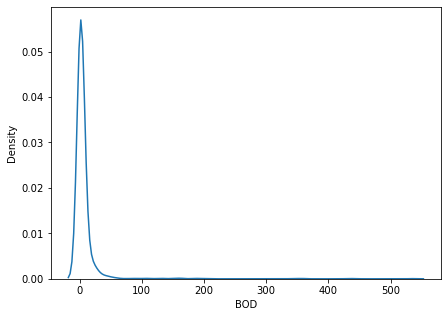

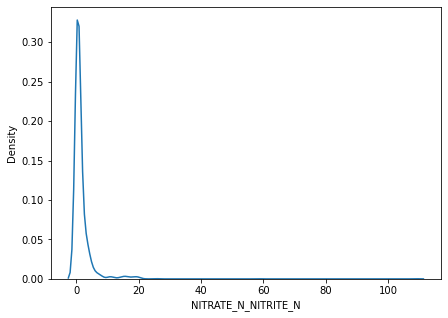

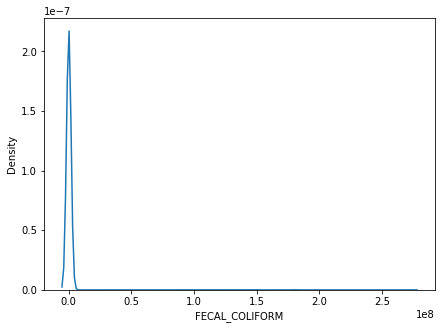

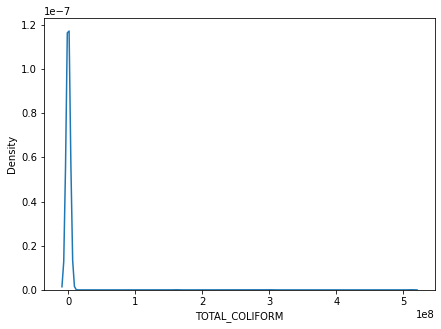

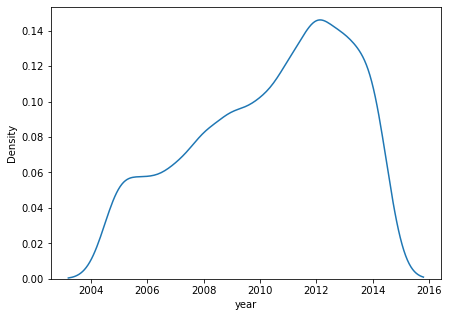

In [30]:
#Tracer PDFs de tous les attributs numériques de l’ensemble de données

df_num_final = df_final.select_dtypes(exclude="object")

def plot_kde(df):
    n_col = df.shape[1]
    for index in range(n_col):
        col_index = df.iloc[:, index]
        fig, ax = plt.subplots(1,1, figsize=(7, 5))
        sns.kdeplot(data=df, x=col_index.name)
        
plot_kde(df_num_final)

In [31]:
# Ici, presque tous les plots kde sont gaussiens 
# Utilisation de la normalisation Z-Score pour détecter les valeurs aberrantes

df_num_final_norm = df_num_final.apply(zscore, axis=0)

def indices_of_greater_than_3(df_norm):
    indices_arr = []
    n_col = df_norm.shape[1]
    for index in range(n_col):
        col_index = df_norm.iloc[:, index]
        greater_than_3 = col_index[col_index > 3]
        greater_than_3_index = greater_than_3.index
        indices_arr.extend(greater_than_3_index)
    return indices_arr

indices_arr = indices_of_greater_than_3(df_num_final_norm)
print("Number of outliers using Z-Score method: ", len(indices_arr))
df_final.iloc[indices_arr, :]


Number of outliers using Z-Score method:  125


,STATION CODE,LOCATIONS,STATE,Temp,DO,PH,CONDUCTIVITY,BOD,NITRATE_N_NITRITE_N,FECAL_COLIFORM,TOTAL_COLIFORM,year
741,2880,NAMBUL RIVER AT BISHNUPUR,MANIPUR,28.0,8.2,7.6,112.0,2.1,0.52,233.0,31.0,2012.0
745,2856,"THOUBAL RIVER AT YAIRIPOK, THOUBAL",MANIPUR,30.0,9.3,7.6,193.0,2.3,0.52,233.0,41.0,2012.0
37,2671,KUNDALIKA RIVER NEAR SALAV BRIDGE (SALINA ZONE...,MAHARASHTRA,25.3,5.3,7.7,24062.0,9.9,1.20,156.0,304.0,2014.0
88,2294,R KALLAI AT KALLAI BRIDGE,KERALA,26.3,3.7,7.7,32005.0,1.2,0.90,40000.0,60392.0,2014.0
108,2304,R MOGRAL AT MOGRAL BR.,KERALA,30.0,5.6,7.2,24360.0,2.1,0.30,92.0,447.0,2014.0
...,...,...,...,...,...,...,...,...,...,...,...,...
432,1023,"GHAGGAR AT MUBARAKPUR REST HOUSE (PATIALA), PU...",PUNJAB,23.3,5.5,7.2,636.0,9.7,4.00,1328.0,4975.0,2013.0
685,1023,GHAGGAR AT MUBARAKPUR REST HOUSE (PATIALA),PUNJAB,21.0,5.5,7.4,635.0,8.8,5.08,1400.0,5500.0,2012.0
172,3023,"VASISTA AT SALEM, D/S OF SAGO INDUSRIES EFFLUE...",TAMILNADU,24.3,0.9,7.6,2039.0,104.5,0.90,272521616.0,511090873.0,2014.0
432,1023,"GHAGGAR AT MUBARAKPUR REST HOUSE (PATIALA), PU...",PUNJAB,23.3,5.5,7.2,636.0,9.7,4.00,1328.0,4975.0,2013.0


In [32]:
df_final.drop(indices_arr, axis=0, inplace=True)
df_final.shape

(1786, 12)

# Feature Engineering

Convertissons nos données en données pandas. Nous le faisons parce que pour former un modèle, nous avons besoin de ce que nous avons pour prédire ce qui ne se trouve pas dans les données. Nous devons donc calculer l’indice de qualité de l’eau qui nécessite de nombreuses étapes, mais qui peut être facilement fait en utilisant pandas et en moins de nombre d’étapes. De plus, nous pourrons visualiser nos données sous forme de tableaux plus efficacement.


In [33]:
# Calculating Water Quality Index of each sample
df_num_final = df_final.select_dtypes(exclude="object")
# Dropping year and Temp attribute because they are not used for computing WQI
df_num_final.drop(["year", "Temp"], axis=1, inplace=True)

# Create a dataframe with three columns
parametre_valeur = pd.DataFrame({
    'Paramètres': ['DO','PH','CONDUCTIVITY','BOD','NITRATE_N_NITRITE_N','FECAL_COLIFORM','TOTAL_COLIFORM'],
    'Si': [10,8.5,1000,5,45,100,1000],#(valeur maximale standard)
    'V_ideal':[14.6,7.0,0,0,0,0,0] # Ideal values of paramters(vIdeal)
})

Somme_Si=0.0
for i in parametre_valeur['Si']:
    Somme_Si+=1/i
    
k=1/Somme_Si 
#Parameter_unit_weights
Wi=list()
for i in parametre_valeur['Si']:
    Wi.append(round(k/i,4))
    
parametre_valeur['wi']=Wi
parametre_valeur

,Paramètres,Si,V_ideal,wi
0,DO,10.0,14.6,0.2213
1,PH,8.5,7.0,0.2604
2,CONDUCTIVITY,1000.0,0.0,0.0022
3,BOD,5.0,0.0,0.4426
4,NITRATE_N_NITRITE_N,45.0,0.0,0.0492
5,FECAL_COLIFORM,100.0,0.0,0.0221
6,TOTAL_COLIFORM,1000.0,0.0,0.0022


In [34]:
# Weight Vector(wi)
wi = parametre_valeur['wi']
# Standard values of parameters(si)
si = parametre_valeur['Si']
# Ideal values of paramters(vIdeal)
vIdeal = parametre_valeur['V_ideal']

In [35]:
def calc_wqi(sample): 
    wqi_sample = 0
    num_col = 7
    for index in range(num_col):
        v_index = sample[index] # Obeserved value of sample at index
        v_index_ideal = vIdeal[index] # Ideal value of obeserved value
        w_index = wi[index] # weight of corresponding parameter of obeserved value
        std_index = si[index] # Standard value recommended for obeserved value
        q_index = (v_index - v_index_ideal) / (std_index - v_index_ideal)
        q_index = q_index * 100 # Final qi value of obeserved value
        wqi_sample += q_index*w_index
    return wqi_sample

In [36]:
# Computing WQI for the whole dataset
def calc_wqi_for_df(df):
    wqi_arr = []
    for index in range(df.shape[0]):
        index_row = df.iloc[index, :]
        wqi_row = calc_wqi(index_row)
        wqi_arr.append(wqi_row)
    return wqi_arr

In [37]:
wqi_arr = calc_wqi_for_df(df_num_final)
# Converting oridnary array to numpy array
wqi_arr = np.array(wqi_arr)
wqi_arr = np.reshape(wqi_arr, (-1, 1))

# Resetting index values of the dataframes
wqi_arr_df = pd.DataFrame(wqi_arr, columns=["WQI"]).reset_index()
df_final = df_final.reset_index()

In [38]:
# Combining dataframe of WQI and dataframe of attributes 
df_wqi = pd.concat([df_final, pd.DataFrame(wqi_arr, columns=["WQI"])], axis=1)
df_wqi.drop("index", axis=1, inplace=True)
df_wqi.shape

(1786, 13)

In [39]:
# These are samples with negative WQI
df_wqi[(df_wqi["WQI"] < 0)]

,STATION CODE,LOCATIONS,STATE,Temp,DO,PH,CONDUCTIVITY,BOD,NITRATE_N_NITRITE_N,FECAL_COLIFORM,TOTAL_COLIFORM,year,WQI
196,3375,LUKHA RIVER AT MYNDIHATI (TRIBUTARY OF LUNAR),MEGHALAYA,20.5,6.7,2.7,1350.0,3.3,1.10,7.0,16.0,2014.0,-6.855044
231,2,"DAMANGANGA AT D/S OF MADHUBAN, DAMAN",DAMAN & DIU,27.0,6.7,0.0,208.0,1.9,0.52,233.0,465.0,2013.0,-61.341117
234,1865,RIVER DHADAR AT KOTHADA,GUJARAT,27.0,6.7,0.0,506.0,1.9,6.00,26.0,227.0,2013.0,-65.303470
446,3375,LUKHA RIVER,MEGHALAYA,21.3,6.8,2.7,1074.0,3.2,2.33,4.0,11.0,2013.0,-8.214971
719,3375,LUKHA RIVER AT MYNDIHATI (TRIBUTARY OF LUNAR),MEGHALAYA,25.0,6.9,2.6,1072.0,3.2,1.17,3.0,21.0,2012.0,-10.579224


In [40]:
# Removing the samples with negative WQI
df_neg_indices = df_wqi[(df_wqi["WQI"] < 0)].index
df_wqi.drop(df_neg_indices, axis=0, inplace=True)

In [41]:
df_wqi.shape

(1781, 13)

In [42]:
df_wqi['quality']=df_wqi["WQI"].apply(lambda x:('Excellent' if (25>=x>=0)  
                                 else('Good' if  (50>=x>=26) 
                                      else('Poor' if (75>=x>=51)
                                          else('Very Poor' if (100>=x>=76) 
                                              else 'Unsuitable for drinking')))))

In [43]:
df_wqi

,STATION CODE,LOCATIONS,STATE,Temp,DO,PH,CONDUCTIVITY,BOD,NITRATE_N_NITRITE_N,FECAL_COLIFORM,TOTAL_COLIFORM,year,WQI,quality
0,1393,"DAMANGANGA AT D/S OF MADHUBAN, DAMAN",DAMAN & DIU,30.6,6.7,7.50,203.0,1.900,0.100,11.0,27.0,2014.0,63.809303,Poor
1,1399,ZUARI AT D/S OF PT. WHERE KUMBARJRIA CANAL JOI...,GOA,29.8,5.7,7.20,189.0,2.000,0.200,4953.0,8391.0,2014.0,175.363506,Unsuitable for drinking
2,1475,ZUARI AT PANCHAWADI,GOA,29.5,6.3,6.90,179.0,1.700,0.100,3243.0,5330.0,2014.0,126.135831,Unsuitable for drinking
3,3181,RIVER ZUARI AT BORIM BRIDGE,GOA,29.7,5.8,6.90,64.0,3.800,0.500,5382.0,8443.0,2014.0,195.105659,Unsuitable for drinking
4,3182,RIVER ZUARI AT MARCAIM JETTY,GOA,29.5,5.8,7.30,83.0,1.900,0.400,3428.0,5500.0,2014.0,141.393246,Unsuitable for drinking
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1781,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU,27.0,6.6,7.81,603.2,2.675,0.263,40.0,191.0,2005.0,77.315135,Very Poor
1782,1450,"PALAR AT VANIYAMBADI WATER SUPPLY HEAD WORK, T...",TAMILNADU,28.0,6.6,7.49,571.5,2.091,0.256,151.0,273.0,2005.0,69.053768,Poor
1783,1403,"GUMTI AT U/S SOUTH TRIPURA,TRIPURA",TRIPURA,28.0,5.4,7.16,75.8,2.092,0.520,404.0,513.0,2005.0,74.670773,Poor
1784,1404,"GUMTI AT D/S SOUTH TRIPURA, TRIPURA",TRIPURA,30.0,5.4,7.37,104.8,1.802,0.215,456.0,557.0,2005.0,76.881207,Very Poor


In [44]:
df_wqi.describe().T.style.background_gradient(subset=['mean','std','50%','count'], cmap='PuBu')

,count,mean,std,min,25%,50%,75%,max
Temp,1781.000000,26.243480,3.230798,10.000000,25.000000,27.000000,28.200000,35.000000
DO,1781.000000,6.431627,1.258807,0.000000,6.000000,6.700000,7.200000,10.000000
PH,1781.000000,7.228125,0.582607,2.900000,6.900000,7.229000,7.600000,9.010000
CONDUCTIVITY,1781.000000,1005.818040,2763.907102,11.000000,83.000000,183.000000,489.000000,18569.000000
BOD,1781.000000,3.961060,7.128550,0.100000,1.100000,1.800000,3.400000,88.000000
NITRATE_N_NITRITE_N,1781.000000,1.119200,1.629170,0.000000,0.263000,0.520000,1.100000,13.200000
FECAL_COLIFORM,1781.000000,2263.444554,8257.256707,0.000000,46.000000,233.000000,672.000000,150250.000000
TOTAL_COLIFORM,1781.000000,7238.859629,40219.201003,0.000000,109.000000,465.000000,1650.000000,967500.000000
year,1781.000000,2010.377316,2.706468,2005.000000,2008.000000,2011.000000,2013.000000,2014.000000
WQI,1781.000000,130.278839,222.201269,16.795814,54.647148,69.851286,94.338196,3524.421534


In [45]:
df_wqi = df_wqi.rename(columns={'STATE': 'state'})

In [46]:
#renaming state names
gdf['st_nm'].replace({"Andaman & Nicobar Island": "Andaman and Nicobar Islands",
                      "Arunanchal Pradesh": "Arunachal Pradesh",
                      'Dadara & Nagar Havelli':'Dadra and Nagar Haveli and Daman and Diu',
                      'Jammu & Kashmir':'Jammu and Kashmir',
                      'NCT of Delhi':'Delhi'}, inplace=True)
df_wqi['state'].replace({"TAMILNADU": "TAMIL NADU"}, inplace=True)
#Capitalizing only the first letter of each word
df_wqi['state'] = df_wqi['state'].str.title()

In [47]:
from shapely.geometry import Polygon, LineString, Point

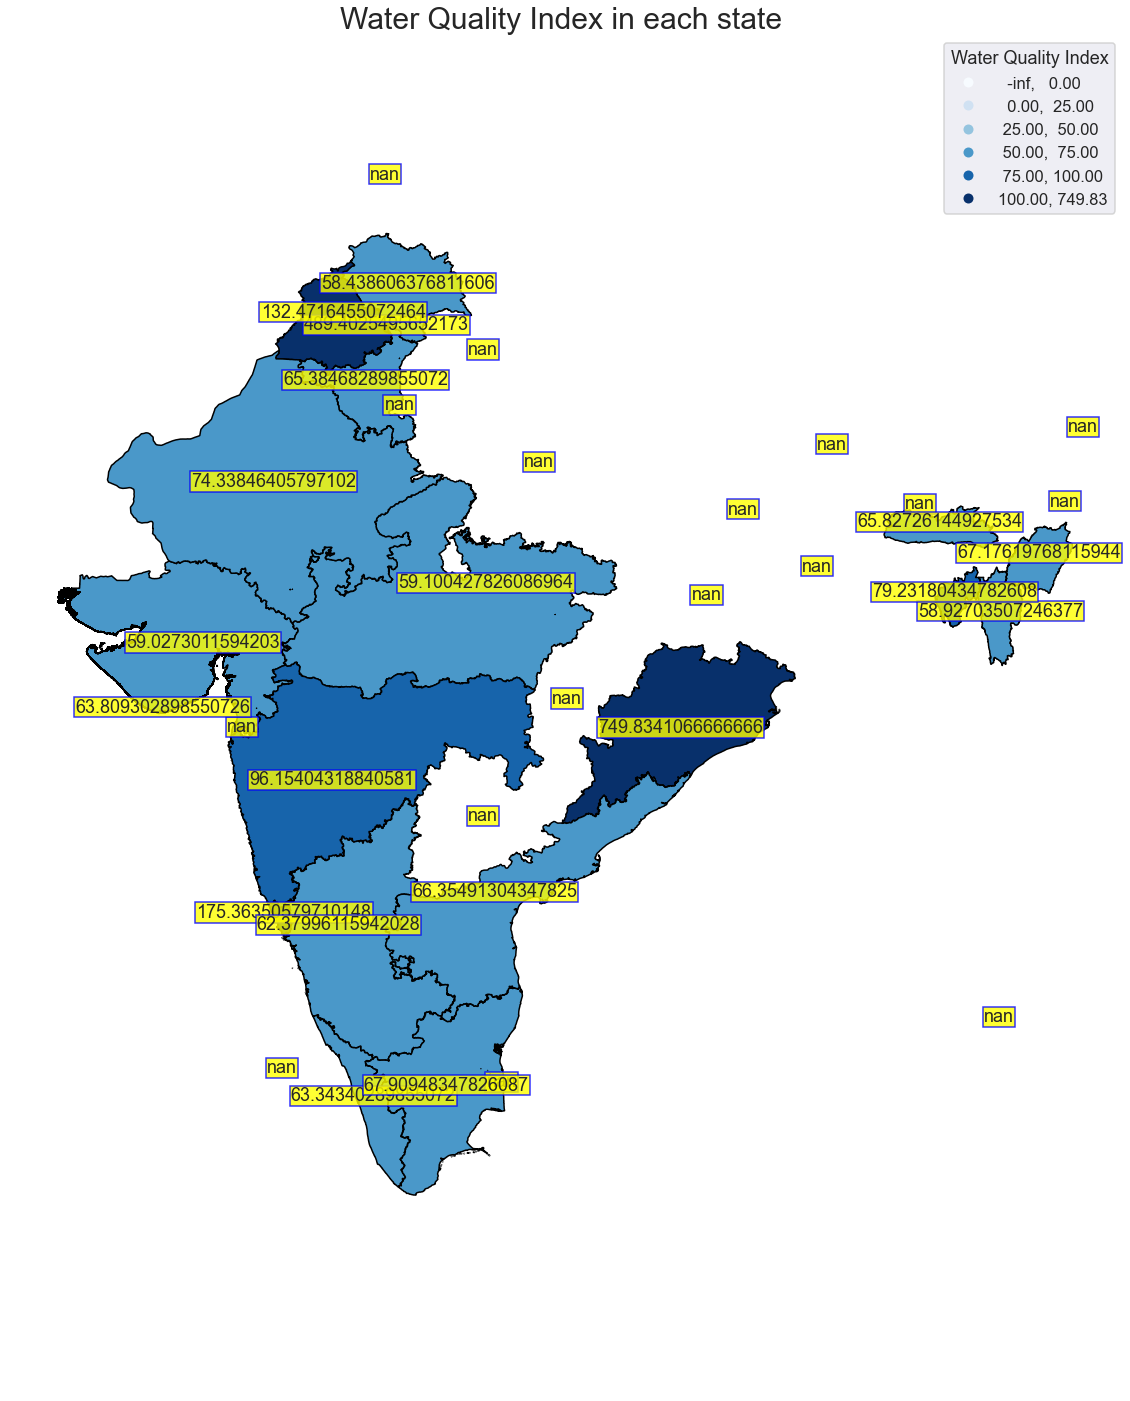

In [48]:
gdf = gdf.rename(columns={"st_nm": "state"})
merged = pd.merge(gdf, df_wqi , how='outer', on='state')

# Remove any rows that have None values in the geometry column
merged = merged[merged['geometry'].notna()]

merged['coords'] = merged['geometry'].apply(lambda x: x.representative_point().coords[:])
merged['coords'] = [coords[0] for coords in merged['coords']]
merged = merged.drop_duplicates(subset ="state")

sns.set_context("talk")
sns.set_style("dark")
cmap = 'Blues'
figsize = (20, 25)
ax = merged.plot(column= 'WQI', cmap=cmap, 
                          figsize=figsize, scheme='User_Defined',
                          classification_kwds=dict(bins=[0,25,50,75,100]),
                          edgecolor='black', legend = True)
for idx, row in merged.iterrows():
    ax.text(row.coords[0], row.coords[1], s=row['WQI'], horizontalalignment='center', bbox={'facecolor': 'yellow', 'alpha':0.8, 'pad': 1, 'edgecolor':'blue'})

ax.get_legend().set_title('Water Quality Index')
ax.set_title("Water Quality Index in each state ", size = 30)

ax.set_axis_off()
plt.axis('equal')
plt.show()


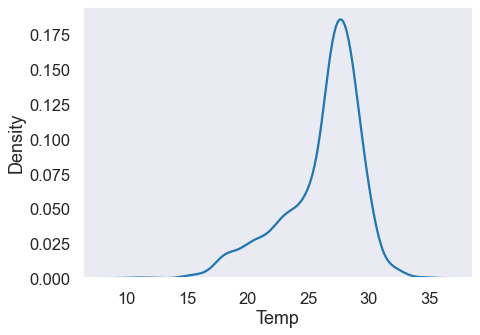

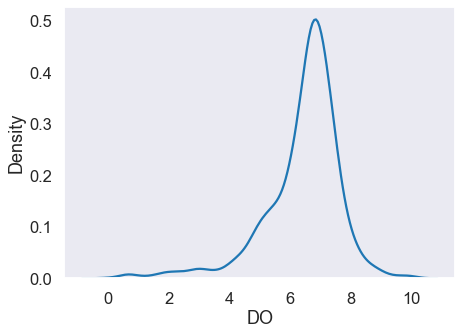

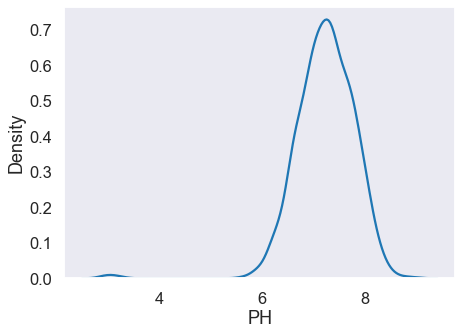

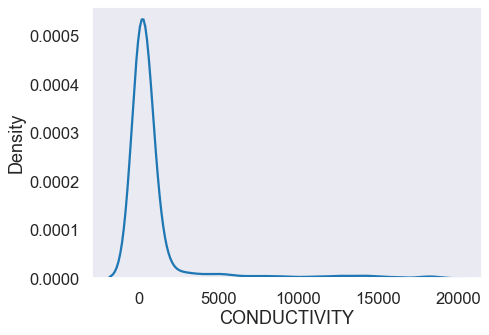

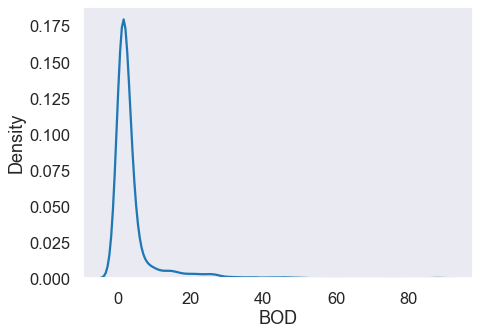

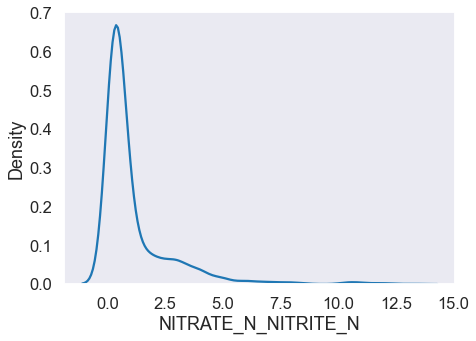

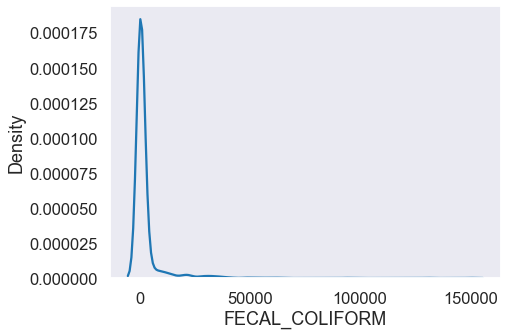

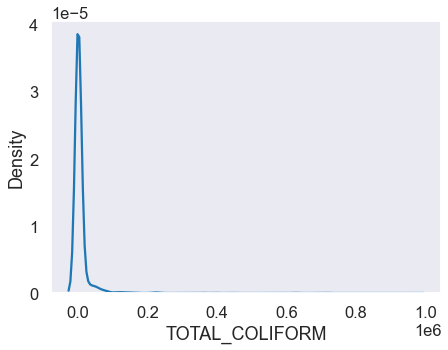

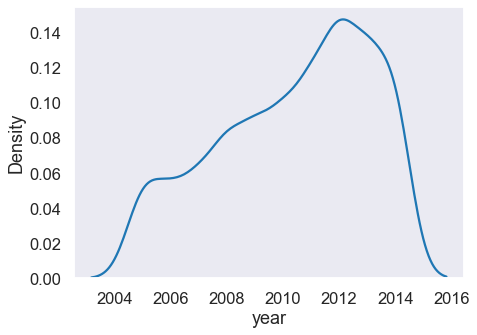

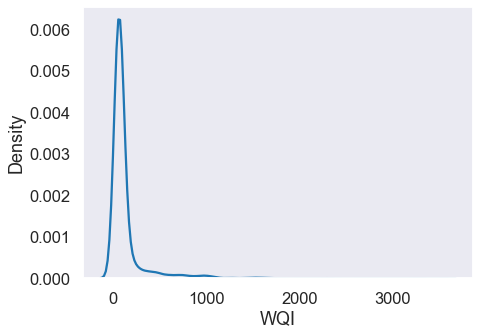

In [49]:
plot_kde(df_wqi.select_dtypes(exclude="object"))

In [ ]:
df_wqi[df_wqi['quality']=='Excellent']

,STATION CODE,LOCATIONS,state,Temp,DO,PH,CONDUCTIVITY,BOD,NITRATE_N_NITRITE_N,FECAL_COLIFORM,TOTAL_COLIFORM,year,WQI,quality
1075,2296,R THALLASSERY AT PATHIPPALAM,Kerala,28.4,6.5,5.80,67.0,0.400,0.54,123.0,520.0,2010.0,24.583323,Excellent
1571,1428,"KYRHUKHLA NEAR SUTNGA KHLIERIAT,JAINTIA HILLS ...",Meghalaya,18.0,6.1,3.10,738.0,5.500,2.73,32.0,45.0,2007.0,23.052331,Excellent
1745,1428,"KHARKHLA NEAR SUTNGA KHLIERIAT,JAINTIA HILLS D...",Meghalaya,18.0,6.4,3.05,605.0,5.067,4.80,18.0,45.0,2005.0,16.795814,Excellent


In [ ]:
df_wqi.shape

(1780, 14)

In [ ]:
n_unsuitable=(df_wqi['quality']=='Unsuitable for drinking').sum()
n_very_poor=(df_wqi['quality']=='Very Poor').sum()
n_poor=(df_wqi['quality']=='Poor').sum()
n_good=(df_wqi['quality']=='Good').sum()
n_excellent=(df_wqi['quality']=='Excellent').sum()

In [ ]:
print(n_excellent)

3


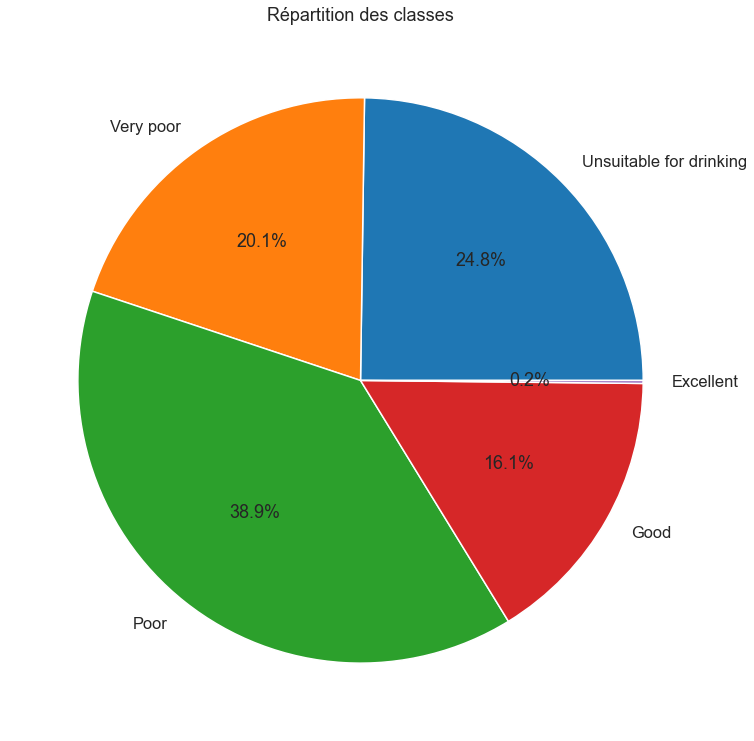

In [ ]:
import matplotlib.pyplot as plt
# Définition des classes et de leurs effectifs
classes = ['Unsuitable for drinking', 'Very poor', 'Poor', 'Good', 'Excellent']
effectifs = [n_unsuitable,n_very_poor,n_poor,n_good,n_excellent]
# Création du diagramme circulaire
fig, ax = plt.subplots()
ax.pie(effectifs, labels=classes, autopct='%2.1f%%')
# Définir la taille de la figure
fig.set_size_inches(14, 13)
# Ajout d'un titre
ax.set_title('Répartition des classes')
# Affichage du diagramme
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.utils import to_categorical

# Charger les données
data = df_wqi

In [ ]:
cols_to_drop=["STATION CODE","LOCATIONS","state","Temp","WQI","year","quality"]

In [ ]:
# Diviser les données en caractéristiques et cibles
X =  data.drop(cols_to_drop, axis=1)
y = data["quality"].values

In [ ]:
# Encoder les labels catégoriels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Redimensionner les données pour les convolutions 1D
X_train = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
# Convertir les labels en one-hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Créer le modèle CNN
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation="relu", input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(10, activation="relu"))
model.add(Dense(y_train.shape[1], activation="softmax"))

# Compiler le modèle
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
# Entraîner le modèle
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)
print(history.history['accuracy'])
print(history.history['loss'])

Epoch 1/50
45/45 [==============================] - 0s 4ms/step - loss: 1.2352 - accuracy: 0.4789 - val_loss: 1.2327 - val_accuracy: 0.4916
Epoch 2/50
45/45 [==============================] - 0s 3ms/step - loss: 1.2322 - accuracy: 0.4867 - val_loss: 1.2167 - val_accuracy: 0.4831
Epoch 3/50
45/45 [==============================] - 0s 3ms/step - loss: 1.2312 - accuracy: 0.4860 - val_loss: 1.2106 - val_accuracy: 0.4916
Epoch 4/50
45/45 [==============================] - 0s 3ms/step - loss: 1.2170 - accuracy: 0.4951 - val_loss: 1.2162 - val_accuracy: 0.5028
Epoch 5/50
45/45 [==============================] - 0s 3ms/step - loss: 1.2536 - accuracy: 0.4972 - val_loss: 1.2058 - val_accuracy: 0.4944
Epoch 6/50
45/45 [==============================] - 0s 3ms/step - loss: 1.2115 - accuracy: 0.5021 - val_loss: 1.2131 - val_accuracy: 0.4803
Epoch 7/50
45/45 [==============================] - 0s 3ms/step - loss: 1.2394 - accuracy: 0.4740 - val_loss: 1.2254 - val_accuracy: 0.4803
Epoch 8/50
45/45 [==

In [ ]:
# Évaluer le modèle sur les données de test
score = model.evaluate(X_test, y_test)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

12/12 [==============================] - 0s 2ms/step - loss: 1.1321 - accuracy: 0.5253
Test loss: 1.1321126222610474
Test accuracy: 0.5252808928489685


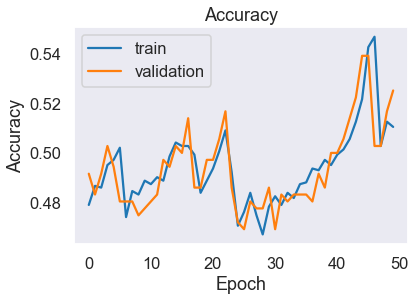

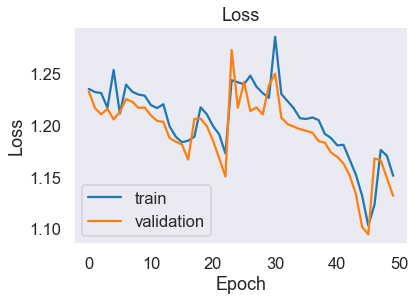

In [ ]:

# Afficher les graphes d'accuracy et loss selon l'epoch
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
features = list(df_wqi.columns)[3:11]
data_f = df_wqi[features]
data_f.describe()

,Temp,DO,PH,CONDUCTIVITY,BOD,NITRATE_N_NITRITE_N,FECAL_COLIFORM,TOTAL_COLIFORM
count,1780.000000,1780.000000,1780.000000,1780.000000,1780.000000,1780.000000,1780.000000,1780.000000
mean,26.241931,6.432263,7.228045,1006.325691,3.961788,1.119716,2264.420646,7242.598876
std,3.231044,1.258875,0.582761,2764.600752,7.130494,1.629483,8259.474360,40230.193629
min,10.000000,0.000000,2.900000,11.000000,0.100000,0.000000,0.000000,0.000000
25%,25.000000,6.000000,6.900000,83.000000,1.100000,0.263000,46.000000,108.750000
50%,27.000000,6.700000,7.224500,183.000000,1.800000,0.520000,233.000000,465.000000
75%,28.200000,7.200000,7.600000,489.250000,3.400000,1.100000,672.500000,1650.000000
max,35.000000,10.000000,9.010000,18569.000000,88.000000,13.200000,150250.000000,967500.000000


In [ ]:
features = list(df_wqi.columns)[:]
data_cluster = df_wqi['quality']
data_cluster.describe()

count     1780
unique       5
top       Poor
freq       692
Name: quality, dtype: object

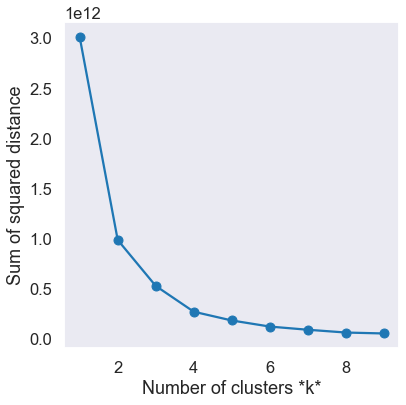

In [ ]:
# normalize data
import pandas as pd
from sklearn import preprocessing
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import seaborn as sns
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(data_f)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');


In [ ]:
data_f

,Temp,DO,PH,CONDUCTIVITY,BOD,NITRATE_N_NITRITE_N,FECAL_COLIFORM,TOTAL_COLIFORM
0,30.6,6.7,7.50,203.0,1.8965,0.100,11.0,27.0
1,29.8,5.7,7.20,189.0,2.0000,0.200,4953.0,8391.0
2,29.5,6.3,6.90,179.0,1.7000,0.100,3243.0,5330.0
3,29.7,5.8,6.90,64.0,3.8000,0.500,5382.0,8443.0
4,29.5,5.8,7.30,83.0,1.9000,0.400,3428.0,5500.0
...,...,...,...,...,...,...,...,...
1780,27.0,7.4,7.00,88.5,0.9770,0.186,27.0,105.0
1781,27.0,6.6,7.81,603.2,2.6750,0.263,40.0,191.0
1782,28.0,6.6,7.49,571.5,2.0910,0.256,151.0,273.0
1783,28.0,5.4,7.16,75.8,2.0920,0.520,404.0,513.0


In [ ]:
Y = data_cluster

In [ ]:
features = list(df_wqi.columns)[3:11]
X = df_wqi[features]
X.describe()
X.dtypes

Temp                   float64
DO                     float64
PH                     float64
CONDUCTIVITY           float64
BOD                    float64
NITRATE_N_NITRITE_N    float64
FECAL_COLIFORM         float64
TOTAL_COLIFORM         float64
dtype: object

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[ 1.34919038,  0.21273941,  0.46679752, ..., -0.62596683,
        -0.27290525, -0.1794082 ],
       [ 1.10152283, -0.58184389, -0.04813777, ..., -0.56458042,
         0.32560606,  0.02855377],
       [ 1.0086475 , -0.10509391, -0.56307306, ..., -0.62596683,
         0.11851291, -0.04755474],
       ...,
       [ 0.54427084,  0.13328108,  0.44963301, ..., -0.53020403,
        -0.25595025, -0.17329167],
       [ 0.54427084, -0.82021888, -0.11679581, ..., -0.36814393,
        -0.22531016, -0.16732433],
       [ 1.16343972, -0.82021888,  0.24365889, ..., -0.55537246,
        -0.21901259, -0.16623031]])

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=30)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
# model = LinearRegression()
# # model = LogisticRegression(solver='liblinear')
# model.fit(X_train,y_train)
# model.score(X_test,y_test)
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)
score = neigh.score(X_test,y_test)
print("score: ",score)
y_pred = neigh.predict(X_test)
print(classification_report(y_test,y_pred, zero_division=1))

score:  0.7247191011235955
                         precision    recall  f1-score   support

              Excellent       1.00      0.00      0.00         1
                   Good       0.69      0.71      0.70        63
                   Poor       0.69      0.83      0.76       130
Unsuitable for drinking       0.94      0.68      0.79        93
              Very Poor       0.62      0.61      0.61        69

               accuracy                           0.72       356
              macro avg       0.59      0.57      0.57       356
           weighted avg       0.74      0.72      0.72       356



C:\Users\amine\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
